In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier


In [2]:
DATA_PATH = os.path.join("..", "data", "Loan_default.csv")
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [3]:
display(df.dtypes.value_counts())
display(df.isna().mean().sort_values(ascending=False).head(20))


object     8
int64      8
float64    2
Name: count, dtype: int64

LoanID            0.0
Age               0.0
HasCoSigner       0.0
LoanPurpose       0.0
HasDependents     0.0
HasMortgage       0.0
MaritalStatus     0.0
EmploymentType    0.0
Education         0.0
DTIRatio          0.0
LoanTerm          0.0
InterestRate      0.0
NumCreditLines    0.0
MonthsEmployed    0.0
CreditScore       0.0
LoanAmount        0.0
Income            0.0
Default           0.0
dtype: float64

In [4]:

assert "Default" in df.columns, "No encuentro la columna 'Default' en el dataset."

y = df["Default"]
X = df.drop(columns=["Default"])

print("X shape:", X.shape)
print("y shape:", y.shape)
display(y.value_counts(dropna=False))


X shape: (255347, 17)
y shape: (255347,)


Default
0    225694
1     29653
Name: count, dtype: int64

Counts:


Default
0    225694
1     29653
Name: count, dtype: int64


Proportions (%):


Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64

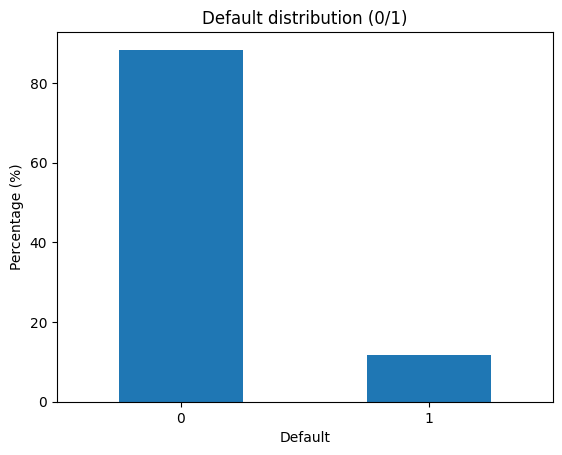

In [5]:
counts = y.value_counts(dropna=False)
props = y.value_counts(normalize=True, dropna=False) * 100

print("Counts:")
display(counts)

print("\nProportions (%):")
display(props)

props.sort_index().plot(kind="bar")
plt.title("Default distribution (0/1)")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.show()


In [6]:
display(
    df
    .groupby("Default")["Income"]
    .describe()
)



,count,mean,std,min,25%,50%,75%,max
Default,,,,,,,,
0,225694.0,83899.165995,38498.801232,15000.0,50994.0,84237.5,117186.75,149999.0
1,29653.0,71844.722659,40785.099507,15004.0,34022.0,66566.0,106895.00,149995.0


In [7]:
#Credit Score

display(
    df
    .groupby("Default")["CreditScore"]
    .describe()
)


,count,mean,std,min,25%,50%,75%,max
Default,,,,,,,,
0,225694.0,576.232270,158.849404,300.0,439.0,577.0,714.0,849.0
1,29653.0,559.286143,158.521855,300.0,421.0,553.0,693.0,849.0


In [8]:
#DTIRatio
display(
    df
    .groupby("Default")["DTIRatio"]
    .describe()
)

,count,mean,std,min,25%,50%,75%,max
Default,,,,,,,,
0,225694.0,0.498602,0.231099,0.1,0.30,0.50,0.70,0.9
1,29653.0,0.512467,0.229160,0.1,0.32,0.52,0.71,0.9


EmploymentType
Unemployed       0.135529
Part-time        0.119652
Self-employed    0.114620
Full-time        0.094634
Name: Default, dtype: float64

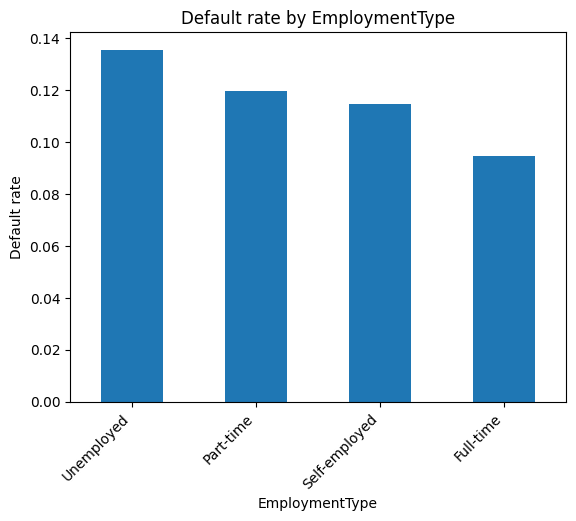

In [9]:
#EmploymentType
default_rate_emp = (
    df
    .groupby("EmploymentType")["Default"]
    .mean()
    .sort_values(ascending=False)
)

display(default_rate_emp)

default_rate_emp.plot(kind="bar")
plt.title("Default rate by EmploymentType")
plt.ylabel("Default rate")
plt.xticks(rotation=45, ha="right")
plt.show()



In [10]:
y = df["Default"]
X = df.drop(columns=["Default"])

X.shape, y.shape


((255347, 17), (255347,))

In [11]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", num_cols)
print("\nCategorical columns:", cat_cols)


Numeric columns: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

Categorical columns: ['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

print("\nDefault rate train:", y_train.mean())
print("Default rate test :", y_test.mean())


Train shape: (204277, 17)
Test shape : (51070, 17)

Default rate train: 0.11612663197521013
Default rate test : 0.11613471705502251


In [13]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

X_train_num = sparse.csr_matrix(X_train[num_cols].to_numpy(dtype=np.float32))
X_test_num  = sparse.csr_matrix(X_test[num_cols].to_numpy(dtype=np.float32))

ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=True)  # use sparse=True if needed

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])

X_train_final = sparse.hstack([X_train_num, X_train_cat], format="csr")
X_test_final  = sparse.hstack([X_test_num, X_test_cat], format="csr")

X_train_final.shape, X_test_final.shape


/Users/denisejones/Desktop/credit-risk-analysis/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


((204277, 204300), (51070, 204300))

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled  = scaler.transform(X_test_final)

X_train_scaled.shape, X_test_scaled.shape


((204277, 204300), (51070, 204300))

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None
)

logreg.fit(X_train_scaled, y_train)

proba_lr = logreg.predict_proba(X_test_scaled)[:, 1]
auc_lr = roc_auc_score(y_test, proba_lr)

auc_lr

from sklearn.metrics import confusion_matrix, classification_report

pred_lr = (proba_lr >= 0.5).astype(int)

confusion_matrix(y_test, pred_lr)

print(classification_report(y_test, pred_lr, digits=4))



              precision    recall  f1-score   support

           0     0.8839    1.0000    0.9384     45139
           1     0.0000    0.0000    0.0000      5931

    accuracy                         0.8839     51070
   macro avg     0.4419    0.5000    0.4692     51070
weighted avg     0.7812    0.8839    0.8294     51070



/Users/denisejones/Desktop/credit-risk-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/denisejones/Desktop/credit-risk-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/denisejones/Desktop/credit-risk-analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

In [16]:
from sklearn.metrics import roc_auc_score

roc_auc_lr = roc_auc_score(y_test, proba_lr)
roc_auc_lr


0.7319447018501375

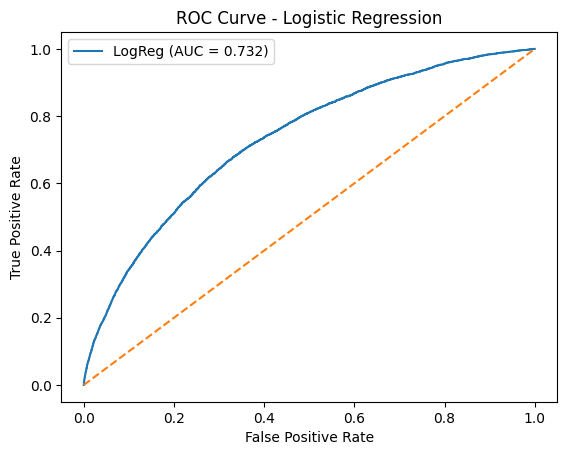

In [17]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)

plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC = {roc_auc_lr:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


In [18]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=200, random_state=42)

X_train_svd = svd.fit_transform(X_train_final)
X_test_svd  = svd.transform(X_test_final)

X_train_svd.shape, X_test_svd.shape


((204277, 200), (51070, 200))

In [19]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

hgb = HistGradientBoostingClassifier(
    random_state=42,
    learning_rate=0.1
)

hgb.fit(X_train_svd, y_train)

proba_hgb = hgb.predict_proba(X_test_svd)[:, 1]
roc_auc_hgb = roc_auc_score(y_test, proba_hgb)

roc_auc_hgb


0.7552325763575849

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

pred_hgb = (proba_hgb >= 0.5).astype(int)

confusion_matrix(y_test, pred_hgb)


array([[44962,   177],
       [ 5666,   265]])

In [21]:
print(classification_report(y_test, pred_hgb, digits=4))


              precision    recall  f1-score   support

           0     0.8881    0.9961    0.9390     45139
           1     0.5995    0.0447    0.0832      5931

    accuracy                         0.8856     51070
   macro avg     0.7438    0.5204    0.5111     51070
weighted avg     0.8546    0.8856    0.8396     51070



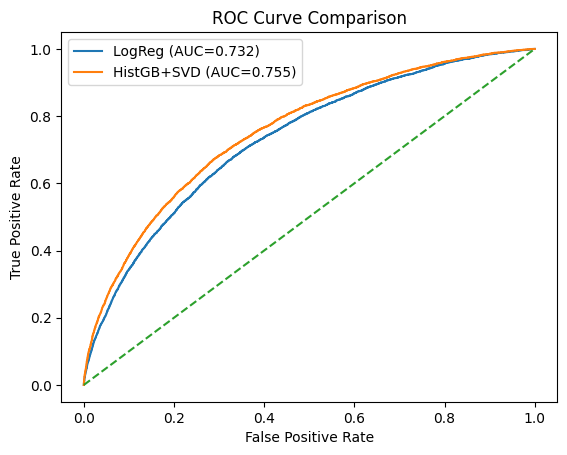

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, proba_hgb)

plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_lr:.3f})")
plt.plot(fpr_hgb, tpr_hgb, label=f"HistGB+SVD (AUC={roc_auc_hgb:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [23]:
#threshold analysis
from sklearn.metrics import confusion_matrix

def eval_threshold(y_true, proba, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
    return {
        "thr": thr,
        "tp": tp, "fn": fn, "fp": fp, "tn": tn,
        "recall_1": tp/(tp+fn) if (tp+fn) else 0,
        "precision_1": tp/(tp+fp) if (tp+fp) else 0
    }

pd.DataFrame([eval_threshold(y_test.values, proba_hgb, t)
              for t in [0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]])


,thr,tp,fn,fp,tn,recall_1,precision_1
0,0.10,4346,1585,16129,29010,0.732760,0.212259
1,0.15,3295,2636,8889,36250,0.555556,0.270437
2,0.20,2464,3467,5106,40033,0.415444,0.325495
3,0.25,1794,4137,2966,42173,0.302479,0.376891
4,0.30,1270,4661,1674,43465,0.214129,0.431386
5,0.40,629,5302,558,44581,0.106053,0.529907
6,0.50,265,5666,177,44962,0.044680,0.599548


In [24]:
import time
import numpy as np
from interpret.glassbox import ExplainableBoostingClassifier

# 1) A denso y float32 (más liviano)
X_test_ebm  = X_test_final.astype(np.float32).toarray()

# 2) Nombres de features (para explicabilidad legible)
ohe_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(ohe_feature_names)

# 3) EBM rápido y controlado
ebm = ExplainableBoostingClassifier(
    random_state=42,
    interactions=0,
    max_bins=64,       # 🔥 acelera mucho
    learning_rate=0.1,
    max_rounds=200,    # 🔥 evita “infinito”
    outer_bags=1,      # 🔥 evita ensambles pesados
    n_jobs=-1
)

t0 = time.time()
ebm.fit(X_train_ebm, y_train)
print("EBM fit seconds:", round(time.time() - t0, 1))

proba_ebm = ebm.predict_proba(X_test_ebm)[:, 1]
roc_auc_ebm = roc_auc_score(y_test, proba_ebm)
print("EBM ROC-AUC:", round(roc_auc_ebm, 4))


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_ebm, tpr_ebm, _ = roc_curve(y_test, proba_ebm)

plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_lr:.3f})")
plt.plot(fpr_hgb, tpr_hgb, label=f"HistGB+SVD (AUC={roc_auc_hgb:.3f})")
plt.plot(fpr_ebm, tpr_ebm, label=f"EBM (AUC={roc_auc_ebm:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Elegimos el cliente más riesgoso del test (posteable)
i = int(np.argmax(proba_ebm))
pd_i = float(proba_ebm[i])
print("Cliente ejemplo (test index):", i, "| PD:", round(pd_i, 4))

# Contribuciones del modelo para ese cliente
scores, contribs = ebm.predict_and_contrib(X_test_ebm[i].reshape(1, -1))

contrib = np.array(contribs[0], dtype=float)

# Algunas versiones traen intercept como último valor
if len(contrib) == len(feature_names) + 1:
    contrib = contrib[:-1]

explain_df = pd.DataFrame({
    "feature": feature_names,
    "contribution": contrib
})

explain_df["abs"] = explain_df["contribution"].abs()
explain_df = explain_df.sort_values("abs", ascending=False).drop(columns="abs")

# Top drivers
top_k = 10
top = explain_df.head(top_k).copy()

# Texto automático "Why now?"
up = top[top["contribution"] > 0]["feature"].head(3).tolist()
down = top[top["contribution"] < 0]["feature"].head(3).tolist()

why = (
    f"↑ Riesgo sube por: {', '.join(up) if up else '—'}\n"
    f"↓ Riesgo baja por: {', '.join(down) if down else '—'}"
)
print("\nWHY NOW?\n" + why)

display(top)

# Gráfico visual (rojo sube riesgo, verde baja)
top_sorted = top.sort_values("contribution")
colors = ["red" if v > 0 else "green" for v in top_sorted["contribution"]]

plt.figure(figsize=(10, 6))
plt.barh(top_sorted["feature"], top_sorted["contribution"], color=colors)
plt.axvline(0, linewidth=1)
plt.title(f"EBM - Top drivers del riesgo (cliente ejemplo)\nPD={pd_i:.2%}")
plt.xlabel("Contribution to risk (log-odds)")
plt.tight_layout()

# Guardar imagen
plt.savefig("ebm_waterfall_linkedin.png", dpi=220, bbox_inches="tight")
plt.show()

print("PNG guardado: ebm_waterfall_linkedin.png")
